# 1 Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotnine as p9
import random

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.decomposition import PCA

pd.options.display.max_columns= None


from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Raleway']

mycolors = ['#447672', '#ee6d71', '#8fc0e0', '#ffb947', '#4e445f', '#d1d882', '#9D7558', 
            '#a7d8d4', '#ffaeac', '#b0b7bd', '#fce4c9', '#bfb4d2', '#5b83a8', '#575757']


p9_template = (p9.theme_seaborn() 
             + p9.theme(
                 rect = p9.element_rect(fill = (0,0,0,0), color=(0,0,0,0)), 
                 panel_background=p9.element_rect(fill='#eaeaf2', alpha=.8),
                 strip_text=p9.element_text(size=14),
                 text=p9.element_text(size=17),
                 subplots_adjust={'hspace': 0.31, 'wspace': 0.31}
             )
            )

mytheme_high = p9_template + p9.theme(figure_size = (10, 7.5))
mytheme_wide = p9_template + p9.theme(figure_size = (15, 7.5))
mytheme_wider = p9_template + p9.theme(figure_size = (15, 5))


In [2]:
data = pd.read_csv('barkbeetle_dataset.csv')

data['timestamp'] = pd.to_datetime(data['timestamp'])

In [3]:
# remove pre 2006 and post feb2020 
data = data[data['timestamp'].isin(pd.date_range(start='2006-01-01', end='2020-02-29', freq='M'))]

In [5]:
# data['demolition_wood'] = data['demolition_wood'] * data['disposing_rate_demolition']

# all
# y = data['infested_wood']
# X = data.drop(['infested_wood', 'forest_ownership', 'fdist_name', 'fdist_newname', 'county_name', 'fdist_id', 'year', 'area_nse', 'area_nsne', 'area_se', 'area_sne'], axis=1)
    
# # aggregate NSW and SW
# data[['infested_wood', 'area_endangered', 'prev_infested_wood', 'prev_infested_wood_rollyr', 'demolition_wood']]= data.groupby(['timestamp', 'fdist_newname'])[['infested_wood', 'area_endangered', 'prev_infested_wood', 'prev_infested_wood_rollyr', 'demolition_wood']].transform('sum')
# data[['disposing_rate_demolition', 'disposing_rate_infested_yr']]= data.groupby(['timestamp', 'fdist_newname'])[['disposing_rate_demolition', 'disposing_rate_infested_yr']].transform('mean')
# data.drop_duplicates(['timestamp', 'fdist_newname'], inplace=True, ignore_index=True)
# 
# data['id'] = data['id'].map(lambda x: '-'.join(x.split('-')[:2]))

# 2 Preparing evaluation functions
## 2.1 Preparation of data for pipelines

In [6]:
def results_setup(X_train, X_val, X_test):    
    # remove and save ids and timestamps from the sets
    # can be used to show model predictions later 
    id_train, ts_train = X_train.pop('id'), X_train.pop('timestamp')
    id_val, ts_val = X_val.pop('id'), X_val.pop('timestamp')
    id_test, ts_test = X_test.pop('id'), X_test.pop('timestamp')
    
    results_df = pd.concat([X_train, X_val])
    results_df['id'] = pd.concat([id_train, id_val])    
    results_df['timestamp'] = pd.concat([ts_train, ts_val])
    results_df['true value'] = pd.concat([y_train, y_val])   
    results_df['set'] = ['train set'] * X_train.shape[0] + ['validation set'] * X_val.shape[0]
    
    return results_df

In [7]:
# TODO: diese Funktion als custom pipeline

def month_num_encoder(X_train, y_train, X_val, X_test):
    '''
    TODO: documentation
    '''
        
    # get a factor for every timeframe
    # factor = how much of the yearly infestation was observed in the respective timeframe
    
    # merge timeframe column from X_train with y_train (target)
    tf_y = pd.DataFrame({'timeframe': X_train['timeframe'], 'target': y_train})
    
    # group by timeframe and take the mean of target
    tf_y = tf_y.groupby('timeframe').mean()
    
    # get the sum of all groups
    total = tf_y['target'].sum()
    
    # make a dictionary that maps the timeframe to the ratio it contributes to the target on average
    transform_dict = tf_y['target'].map(lambda x: x/total).to_dict()
    
    # use these factors (one numerical feature) in train, val and test sets
    # instead of the timeframe feature (categorial with 8 categories)
    # since we only used the knowledge on our targets of the train set (y_train) there is no data leakage 
    
    new_X_train = X_train.copy()
    new_X_train['timeframe'] = new_X_train['timeframe'].map(lambda x: transform_dict.get(x))
    new_X_val = X_val.copy()
    new_X_val['timeframe'] = new_X_val['timeframe'].map(lambda x: transform_dict.get(x))
    new_X_test = X_test.copy()
    new_X_test['timeframe'] = new_X_test['timeframe'].map(lambda x: transform_dict.get(x))
    
    return new_X_train, new_X_val, new_X_test

## 2.2 Fitting the pipelines

In [8]:
def crossvalscores(pipelines, X_train, y_train):
    '''
    TODO
    '''
    # Making predictions on the training set using cross validation
    # cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
    
    for pipe in pipelines:
        print(f'Cross validation scores for {pipe.steps[-1][1]}:')
        y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)
        # Calculating the mean sqaured error, mean absolute error and explained variance for 
        y_train_predicted = y_train_predicted
        print('-------------------------')
        print('MAE: {:.2f}'.format(mean_absolute_error(y_train, y_train_predicted)))
        print('RMSE: {:.2f}'.format(mean_squared_error(y_train, y_train_predicted, squared=False)))
        print('Explained Variance: {:.2f}'.format(explained_variance_score(y_train, y_train_predicted)))
        print('\n')

In [9]:
def randomsearchcv(grids, grid_dict, X_train, y_train, X_val, y_val):
    
    # Fit the grid search objects
    print('Performing model optimizations...')
    best_mae = np.inf
    best_models = {}
    for idx, rs in enumerate(grids):
        print(f'\nEstimator: {grid_dict[idx]}')	
        # Fit grid search	
        rs.fit(X_train, y_train)
        # Best params
        print(f'Best params: {rs.best_params_}')
        # Best training data accuracy
        print(f'Best training MAE: {-rs.best_score_:.2f}') 
        # Predict on validation data with best params
        best_model = rs.best_estimator_    
        y_val_pred = best_model.predict(X_val)
        # Test data accuracy of model with best params
        print(f'Validation set MAE for best params: {mean_absolute_error(y_val, y_val_pred):.2f}')
        # save best result of search in best_models
        best_models[idx] = best_model
        # Track best (highest MAE) model from all estimators
        if mean_absolute_error(y_val, y_val_pred) < best_mae:
            best_mae = mean_absolute_error(y_val, y_val_pred)
            best_rs = rs
            best_reg = idx
    
    
    for idx, model in best_models.items():
    
        y_val_pred = model.predict(X_val)
        print(f'\n\nSummary of validation set errors')
        print(f'{grid_dict.get(idx)}:')
        print('-------------------------')
        print("MAE: {:.2f}".format(mean_absolute_error(y_val, y_val_pred)))
        print("RMSE: {:.2f}".format(mean_squared_error(y_val, y_val_pred, squared=False)))
        print("Explained Variance: {:.2f}\n".format(explained_variance_score(y_val, y_val_pred)))
    
    print(f'\nClassifier with best validation set MAE: {grid_dict[best_reg]}')
    
    return best_models

    # Save best grid search pipeline to file
    #dump_file = 'best_gs_pipeline.pkl'
    #joblib.dump(best_gs, dump_file, compress=1)
    #print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

## 2.3 Model Evaluation

In [10]:
def plot_results(results_df, best_models, grid_dict, X_train, X_val, y_train, y_val):
    scores = []
    for idx, model in best_models.items():
        name = grid_dict.get(idx)
        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_train)
        
        # save the predictions so we can compare them in a later plot
        results_df[name] = np.concatenate([y_train_pred, y_val_pred])
        scores.append([name, 
                       mean_absolute_error(y_train, y_train_pred),
                       mean_squared_error(y_train, y_train_pred, squared=False),
                       explained_variance_score(y_train, y_train_pred),
                       'training set'
                      ])
            
        scores.append([name, 
                       mean_absolute_error(y_val, y_val_pred),
                       mean_squared_error(y_val, y_val_pred, squared=False),
                       explained_variance_score(y_val, y_val_pred),
                       'validation set'
                      ])
    
    scores = pd.DataFrame(scores, columns=['model', 'Mean Absolute Error', 'Root Mean Squared Error', 'Explained Variance', 'set'])
    
    # plot comparison of model scores

    draw = pd.melt(scores, id_vars=['model','set'])
    
    (p9.ggplot(draw)
     + p9.geom_col(p9.aes('set', 'value', fill='model'), position='dodge')
     + p9.facet_wrap('variable', scales='free_y')
     + p9.scale_fill_manual(mycolors[:5])
     + p9.ylab('metric value') + p9.xlab('')
     + mytheme_wide
    ).draw();
    
    ###########################################
    # plot predictions
    top_models = list(scores[scores['set'] == 'validation set'].sort_values('Mean Absolute Error', ascending=True)['model'])
    
    id_subset = np.random.choice(results_df['id'].unique(), 5, replace=False)
    
    for ID in results_df['id'].unique():
        draw = results_df[results_df['id'] == ID]
        draw = pd.melt(draw, id_vars=['id', 'timestamp', 'set'], value_vars=[
            'true value', 
            top_models[0], 
            #top_models[1], top_models[2]
        ])
        validation_ts = draw[draw['set'] == 'validation set']['timestamp']
        
        p=(p9.ggplot(draw)
            + p9.geom_vline(xintercept=validation_ts, color='red', size=.5, linetype='dotted', alpha=.5)
            + p9.geom_line(p9.aes('timestamp', 'value', color='variable'))
            + p9.scale_color_manual([
                mycolors[1], 
                #mycolors[1], mycolors[2], 
                'black'], name='model')
            + p9.xlab('date') + p9.ylab(r'accrued infested wood in solid m$^3$')
            + p9.labels.ggtitle(ID)
            + mytheme_wide
        )
        p.save(f'{ID}.png', verbose=False)
        
        if ID in id_subset:
            p.draw()
            
    ###########################################
    # importances
    importances_names = X_train.columns
    importances_xbgr = best_models[0]['regressor'].feature_importances_
    importances_rfr = best_models[1]['regressor'].feature_importances_
    importances_gbr = best_models[2]['regressor'].feature_importances_
    
    
    draw = pd.melt(pd.DataFrame([importances_xbgr, importances_rfr, importances_gbr], 
                                columns=importances_names, 
                                index=['XGBoost', 'Random Forest', 'Gradient Boosted Trees']), 
                   ignore_index=False)
    (
        p9.ggplot(draw)
        + p9.geom_col(p9.aes('reorder(variable, -value)', 'value', fill=draw.index), position='dodge')
        + p9.scale_fill_manual([mycolors[0], mycolors[2], mycolors[4]], name='model') # each color manually so they match the other plots
        + p9.xlab('feature') + p9.ylab('importance')
        + mytheme_wide
        + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
    ).draw();

_______________________________________________________________________________________________________________________________________

# 3 Baseline Model

# 4 Model with frugal approach

## 4.1 Feature selection

In [11]:
# pre-filter for features and train test split to prevent data leakage
y = data['infested_wood']
X = data[[
    'timestamp', 'id', 
    'area_endangered', 'timeframe', #'centroid_ycoord', #'centroid_xcoord'
    'HS16', 'RRK', 
    'prev_infested_wood', 'prev_infested_wood_ofo',
    'demolition_wood', 
    'prev_infested_wood_rollyr', 
    # 'disposing_rate_demolition', 'disposing_rate_infested_yr',
    'RRK_rollsr', #'HS16_rollyr', 
    #'RRK_rollyr'
]]

## 4.2 train-val-test split

In [12]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# make train set according to train_ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1 - train_ratio, 
                                                    random_state=0)

# make validation and test set according to val_ratio and test_ratio
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + val_ratio), 
                                                random_state=0, 
                                                shuffle=False)  # shuffle already done in first split

# Show the results of the split
print (f'Training set has {X_train.shape[0]} samples.')
print (f'Validation set has {X_val.shape[0]} samples.')
print (f'Testing set has {X_test.shape[0]} samples.')

Training set has 9515 samples.
Validation set has 1189 samples.
Testing set has 1190 samples.


## 4.3 Preparations

In [13]:
# remove id and timestamp and set up results dataframe
results_df = results_setup(X_train, X_val, X_test)

In [14]:
# use function to encode the months in timeframe column
X_train, X_val, X_test = month_num_encoder(X_train, y_train, X_val, X_test)

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 3409 to 3092
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_endangered            9515 non-null   float64
 1   timeframe                  9515 non-null   float64
 2   HS16                       9515 non-null   float64
 3   RRK                        9515 non-null   float64
 4   prev_infested_wood         9513 non-null   float64
 5   prev_infested_wood_ofo     9513 non-null   float64
 6   demolition_wood            9515 non-null   float64
 7   prev_infested_wood_rollyr  9500 non-null   float64
 8   RRK_rollsr                 9502 non-null   float64
dtypes: float64(9)
memory usage: 743.4 KB


## 4.4 Pipeline Setup

In [16]:
# Creating list for categorical predictors/features 
# Should not have any but we leave it in for robustness sake (TODO:remove)
cat_features = list(X_train.columns[X_train.dtypes==object])
print(f'Categorical features: {cat_features}')

# Creating list for numerical predictors/features
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(X_train.columns[X_train.dtypes!=object])
print(f'Numerical features: {num_features}')

Categorical features: []
Numerical features: ['area_endangered', 'timeframe', 'HS16', 'RRK', 'prev_infested_wood', 'prev_infested_wood_ofo', 'demolition_wood', 'prev_infested_wood_rollyr', 'RRK_rollsr']


In [17]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()) # Standardscaler not needed if we use Decision Tree Based Models
])

# Pipeline for categorical features 
# don't have those for now but keep it in for robustness' sake
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [18]:

# Building a full pipeline with our preprocessor and a Regressor
pipe_xgbr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror'
    ))
])

pipe_rfr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        criterion='mae', 
        random_state=0, 
        n_jobs=-1
    ))
])

pipe_gbr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        criterion='mae',  
        random_state=0
    ))
])

pipe_knr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(
        n_jobs=-1
    ))
])

pipe_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(
        max_iter=50000
    ))
])

pipelines = [pipe_xgbr, pipe_rfr, pipe_gbr, pipe_knr, pipe_svr]

In [19]:
#####################################################################
# optimizing - defining parameter space for search
search_params_xgbr = [{                 
    'regressor__learning_rate'    : [0.01, 0.015, 0.02, 0.05, 0.10] ,
    'regressor__max_depth'        : [8, 10, 12, 14, 16],
    'regressor__subsample'        : [0.45, 0.55, 0.65, 0.75],
    'regressor__min_child_weight' : [1, 2, 3, 4],
    'regressor__gamma'            : [0.0, 0.05, 0.1, 0.2 , 0.3],
    'regressor__colsample_bytree' : [0.5, 0,6, 0.7, 1],
    'regressor__colsample_bylevel': [0.75, 1],
    'regressor__colsample_bynode' : [0.75, 1],
    'regressor__n_estimators'     : [75, 100, 125, 175],
}]

search_params_rfr = [{    
    'regressor__max_depth'         : [10, 12, 15, 17, 20],
    'regressor__min_samples_split' : [2, 5, 8],
    'regressor__max_features'      : ['log2', 'sqrt', None],
    'regressor__bootstrap'         : [True, False],
    'regressor__min_samples_leaf'  : [2, 3, 4, 5, 6],
    'regressor__n_estimators'      : range(75,200,25),
}]
 
search_params_gbr = [{ 
    'regressor__learning_rate'     : [0.05, 0.1, 0.15, 0.2, 0.25],
    'regressor__min_samples_split' : np.linspace(0.01, 0.15, 8),
    'regressor__min_samples_leaf'  : np.linspace(0.01, 0.15, 8),
    'regressor__max_depth'         : [5, 10, 15, 20, 25],
    'regressor__max_features'      : ['log2','sqrt', None],
    'regressor__subsample'         : [0.8, 0.9, 1.0, 1.1, 1.2],
    'regressor__n_estimators'      : range(125,326,50),    
}]

search_params_knr = [{
    'regressor__metric'            : ['manhattan', 'euclidean', 'minkowski'],
    'regressor__n_neighbors'       : range(3, 81, 1),
    'regressor__weights'           : ['uniform', 'distance'],   
}]

search_params_svr = [{ 
    'regressor__kernel'            : ['rbf', 'sigmoid', 'poly', 'linear'],
    'regressor__degree'            : [2, 3],
    'regressor__gamma'             : np.linspace(0.0001, 10, 25),
    'regressor__C'                 : np.linspace(0.1, 100, 25),
}]


In [20]:
scoring = 'neg_mean_absolute_error'
cv = 3
n_jobs=-1
verbose=1
random_state=0

# specify search hyperparameters
rs_xgbr = RandomizedSearchCV(pipe_xgbr, 
                             param_distributions=search_params_xgbr, 
                             cv=cv, 
                             scoring=scoring, 
                             verbose=verbose, 
                             n_jobs=n_jobs, 
                             random_state=random_state, 
                             n_iter=400)

rs_rfr = RandomizedSearchCV(pipe_rfr, 
                            param_distributions=search_params_rfr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=8)

rs_gbr = RandomizedSearchCV(pipe_gbr, 
                            param_distributions=search_params_gbr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=10)

rs_knr = RandomizedSearchCV(pipe_knr, 
                            param_distributions=search_params_knr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=50)

rs_svr = RandomizedSearchCV(pipe_svr, 
                            param_distributions=search_params_svr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=150)

grids = [rs_xgbr, rs_rfr, rs_gbr, rs_knr, rs_svr]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'XGBoost', 1: 'Random Forest', 
             2: 'Gradient Boosted Trees', 3: 'KNeighbors', 
             4: 'Support Vector Regression'}

## 4.5 Model Training

In [21]:
crossvalscores(pipelines, X_train, y_train)

Cross validation scores for XGBRegressor(objective='reg:squarederror'):
-------------------------
MAE: 218.62
RMSE: 1797.26
Explained Variance: 0.42


Cross validation scores for RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=0):
-------------------------
MAE: 210.06
RMSE: 1694.36
Explained Variance: 0.48


Cross validation scores for GradientBoostingRegressor(criterion='mae', random_state=0):
-------------------------
MAE: 194.24
RMSE: 1728.67
Explained Variance: 0.46


Cross validation scores for KNeighborsRegressor(n_jobs=-1):
-------------------------
MAE: 218.61
RMSE: 1756.58
Explained Variance: 0.45


Cross validation scores for SVR(max_iter=50000):
-------------------------
MAE: 256.51
RMSE: 2368.45
Explained Variance: 0.00




In [22]:
best_models = randomsearchcv(grids, grid_dict, X_train, y_train, X_val, y_val)

Performing model optimizations...

Estimator: XGBoost
Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   44.0s finished


Best params: {'regressor__subsample': 0.45, 'regressor__n_estimators': 125, 'regressor__min_child_weight': 1, 'regressor__max_depth': 16, 'regressor__learning_rate': 0.02, 'regressor__gamma': 0.0, 'regressor__colsample_bytree': 1, 'regressor__colsample_bynode': 0.75, 'regressor__colsample_bylevel': 0.75}
Best training MAE: 185.73
Validation set MAE for best params: 180.66

Estimator: Random Forest
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:  3.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.1min finished


Best params: {'regressor__n_estimators': 125, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 5, 'regressor__max_features': 'log2', 'regressor__max_depth': 12, 'regressor__bootstrap': True}
Best training MAE: 186.06
Validation set MAE for best params: 166.44

Estimator: Gradient Boosted Trees
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.3min finished


Best params: {'regressor__subsample': 1.0, 'regressor__n_estimators': 275, 'regressor__min_samples_split': 0.12999999999999998, 'regressor__min_samples_leaf': 0.03, 'regressor__max_features': 'log2', 'regressor__max_depth': 25, 'regressor__learning_rate': 0.1}
Best training MAE: 219.21
Validation set MAE for best params: 232.86

Estimator: KNeighbors
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best params: {'regressor__weights': 'distance', 'regressor__n_neighbors': 21, 'regressor__metric': 'manhattan'}
Best training MAE: 197.38
Validation set MAE for best params: 185.26

Estimator: Support Vector Regression
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.3min finished
C:\Users\Yannic\.conda\envs\python377\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Best params: {'regressor__kernel': 'linear', 'regressor__gamma': 6.2500374999999995, 'regressor__degree': 3, 'regressor__C': 29.237500000000004}
Best training MAE: 190.31
Validation set MAE for best params: 195.23
Summary of validation set errors
XGBoost:
-------------------------
MAE: 180.66
RMSE: 1340.64
Explained Variance: 0.56

Summary of validation set errors
Random Forest:
-------------------------
MAE: 166.44
RMSE: 1266.76
Explained Variance: 0.61

Summary of validation set errors
Gradient Boosted Trees:
-------------------------
MAE: 232.86
RMSE: 1814.91
Explained Variance: 0.20

Summary of validation set errors
KNeighbors:
-------------------------
MAE: 185.26
RMSE: 1378.01
Explained Variance: 0.54

Summary of validation set errors
Support Vector Regression:
-------------------------
MAE: 195.23
RMSE: 1420.24
Explained Variance: 0.51


Classifier with best validation set MAE: Random Forest


## 4.6 Model Evaluation

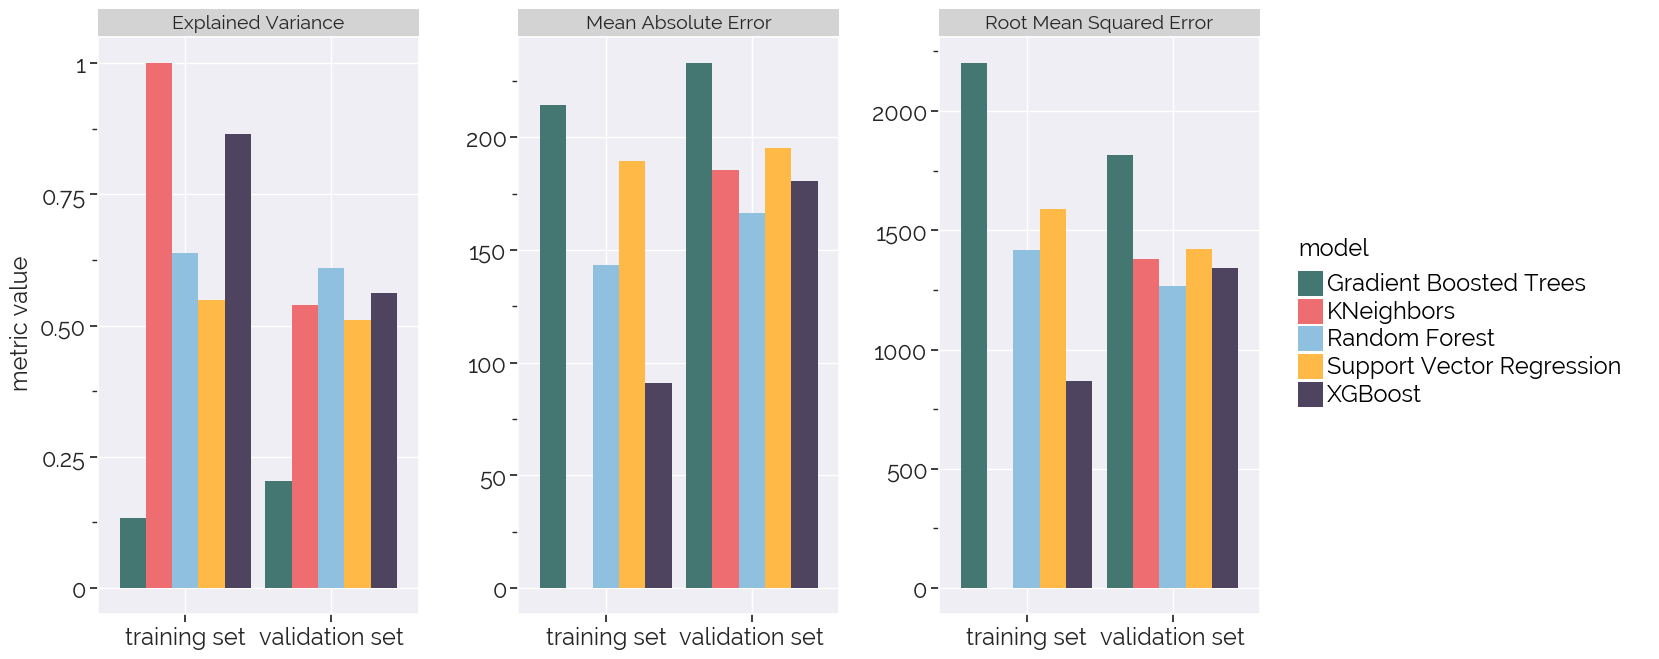

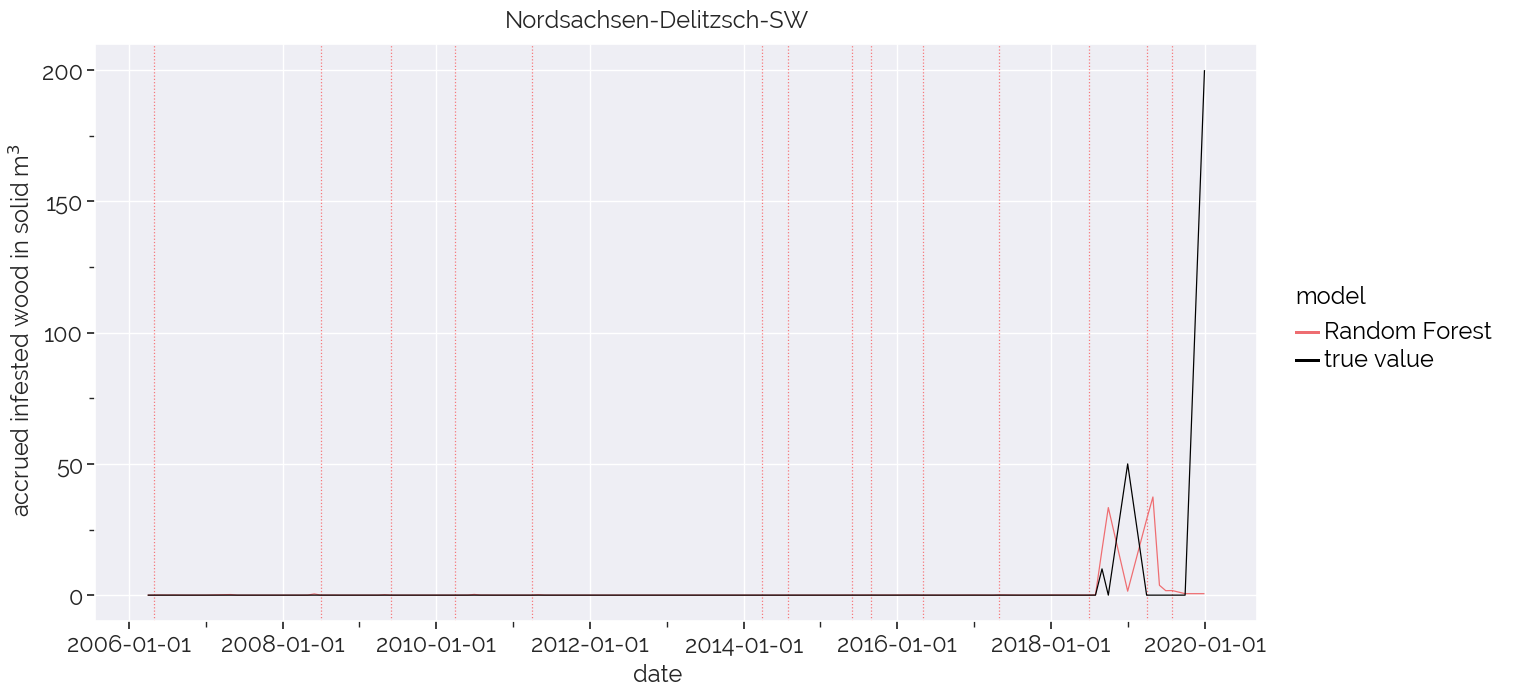

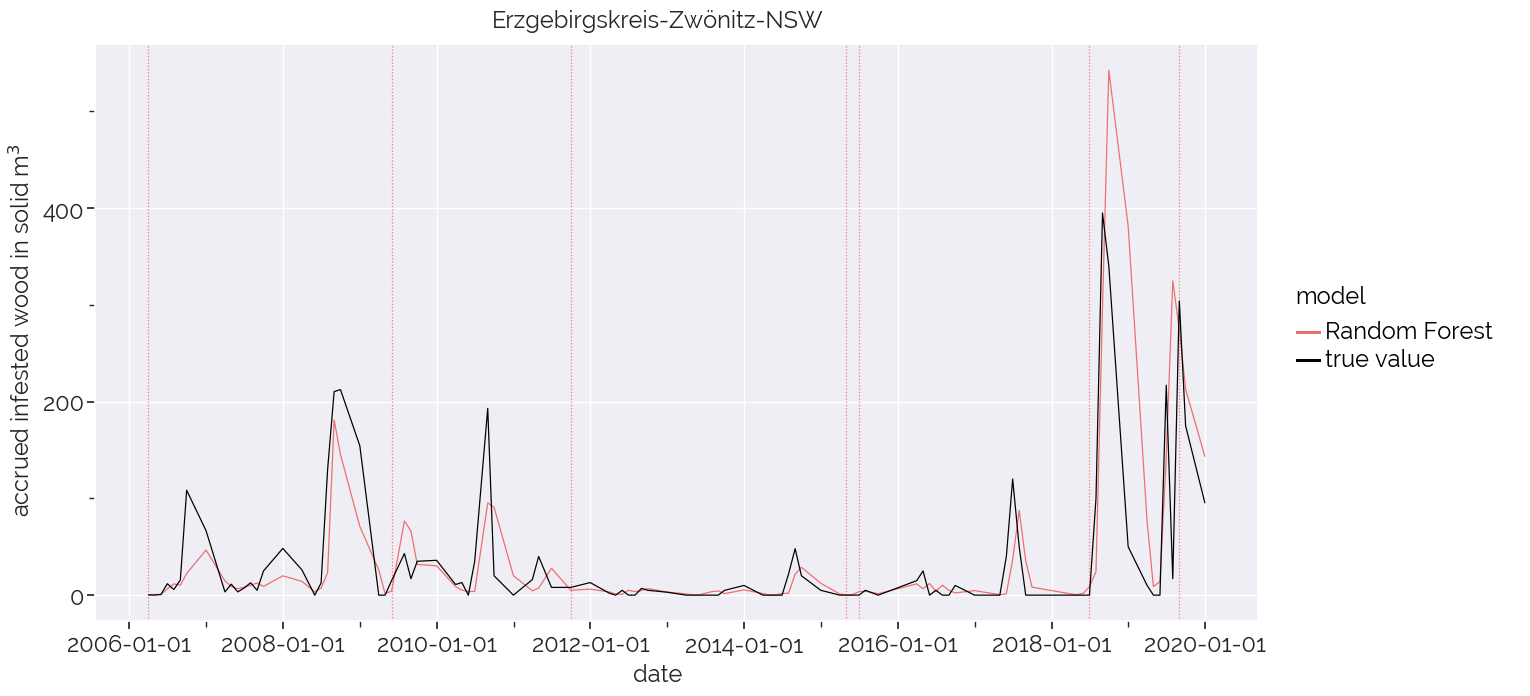

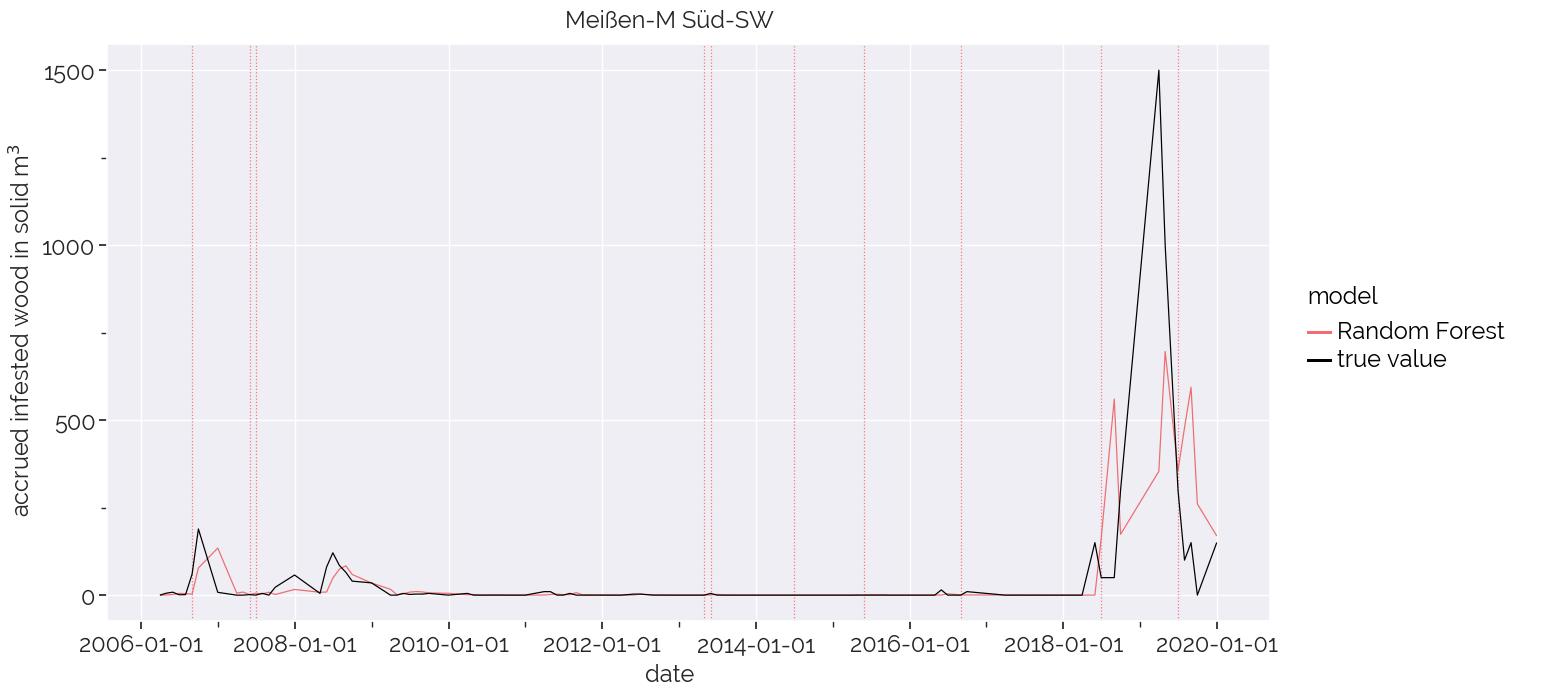

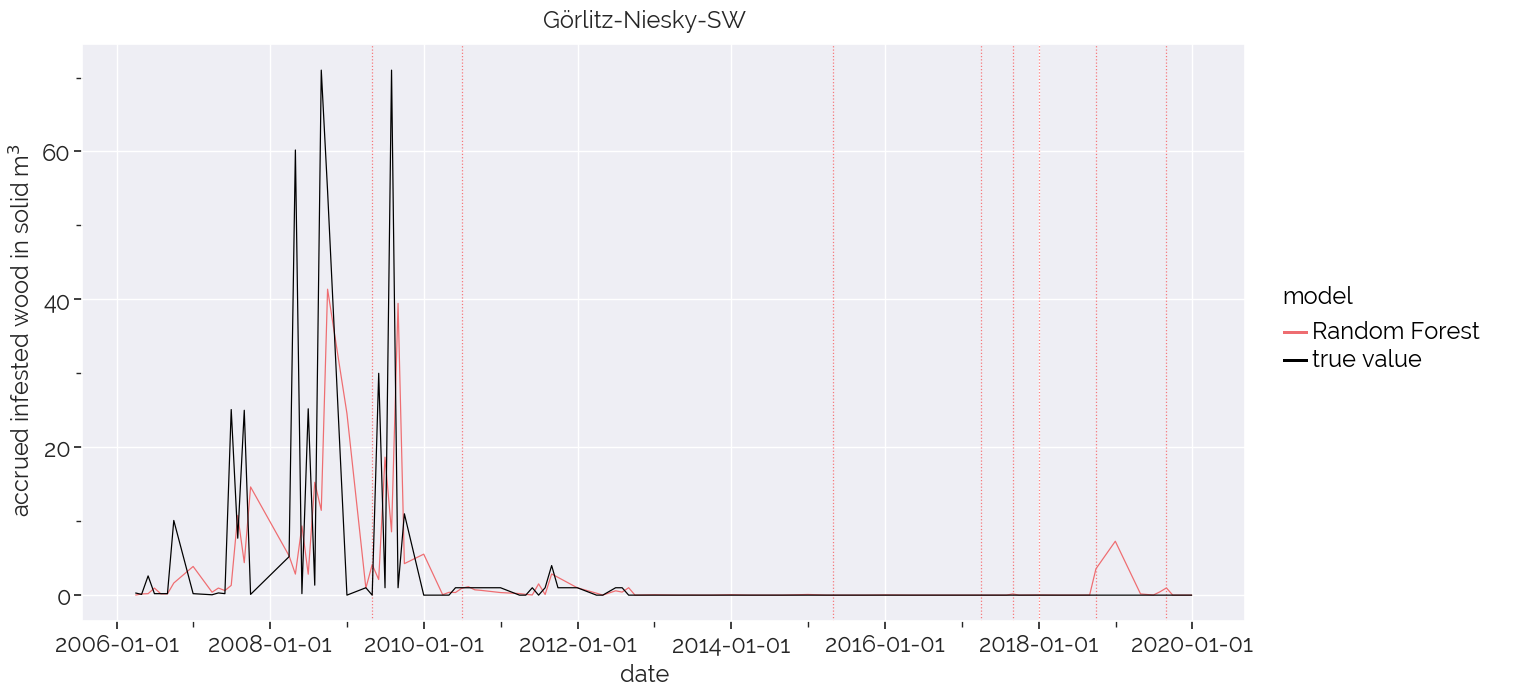

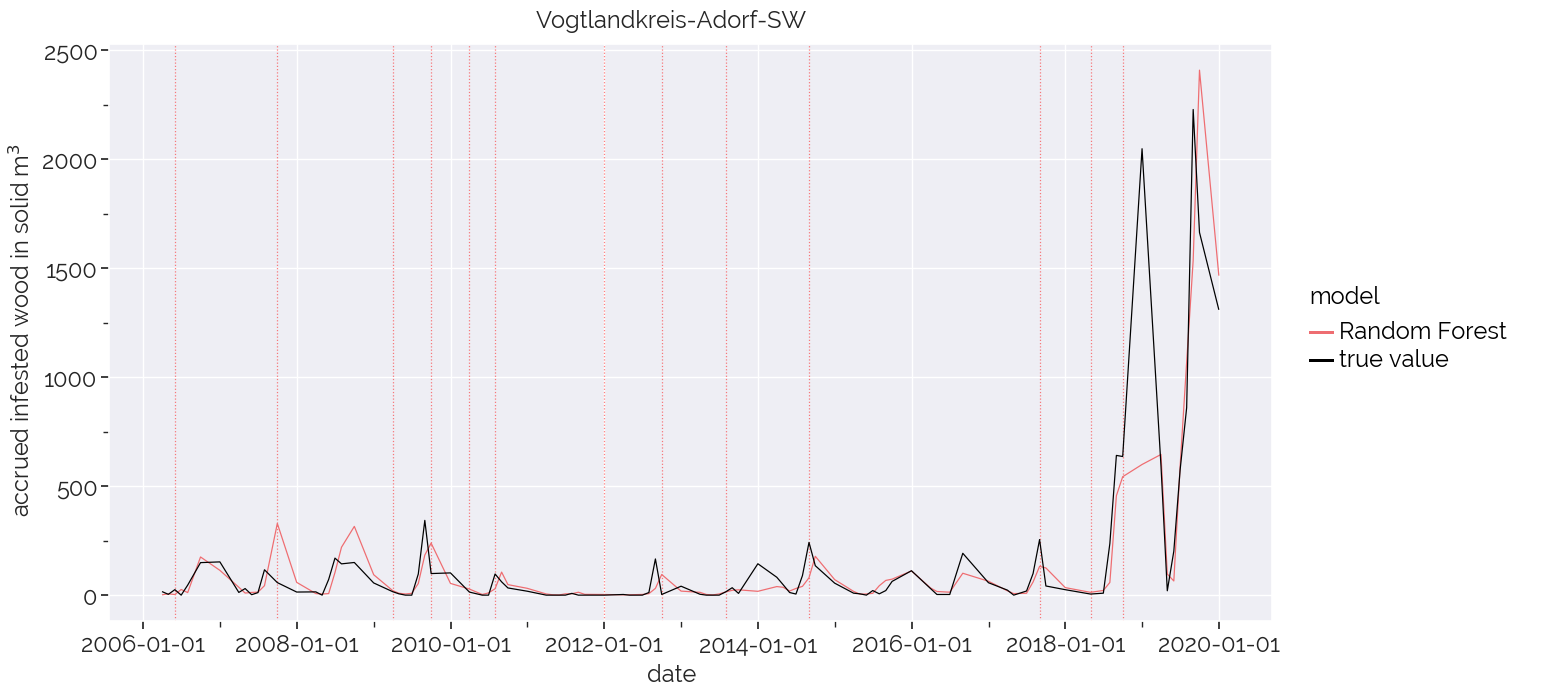

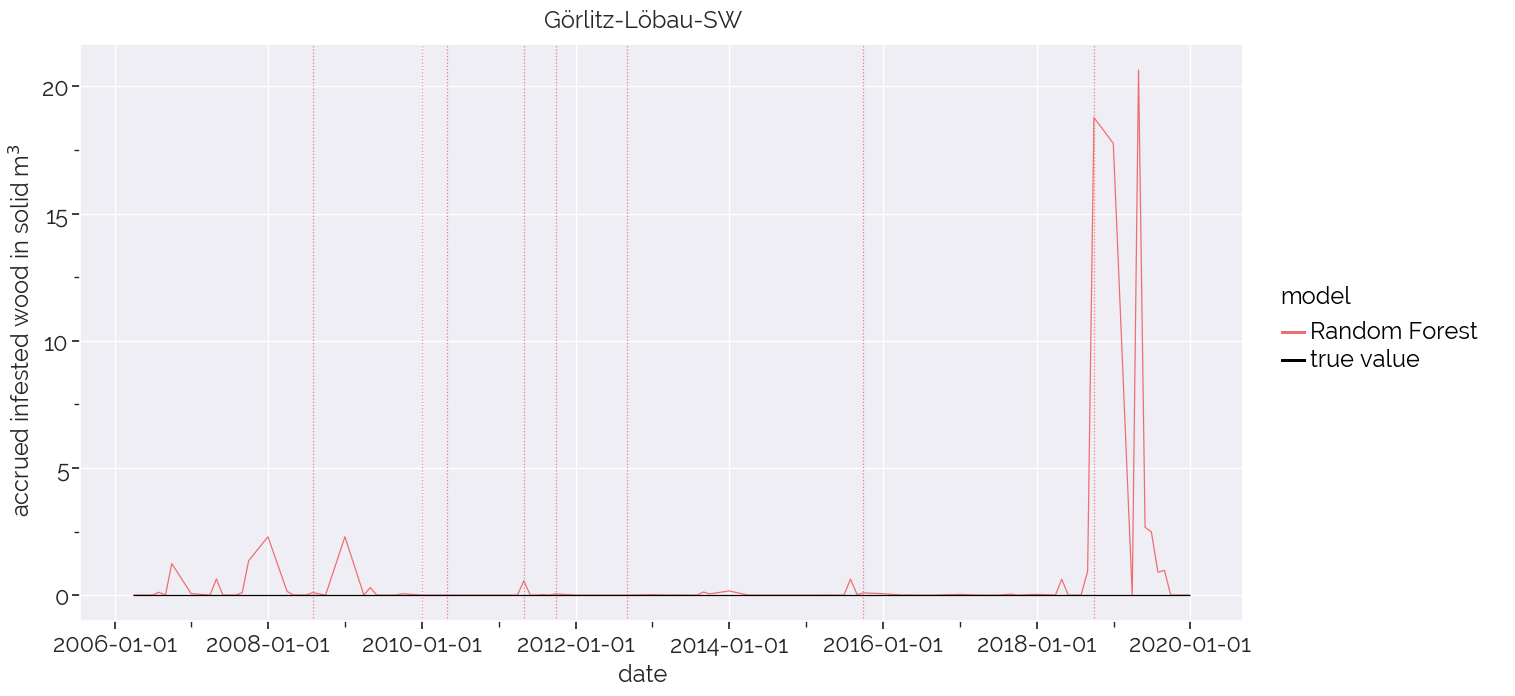

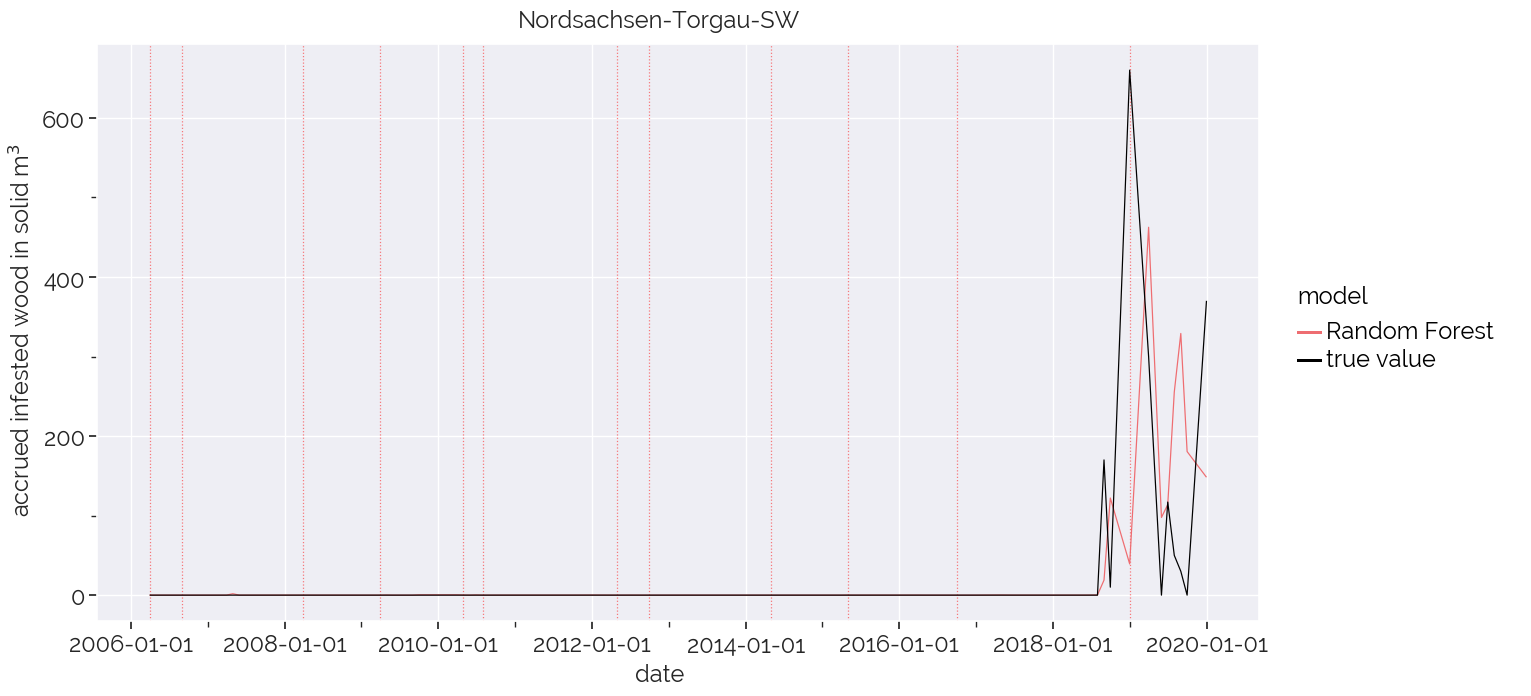

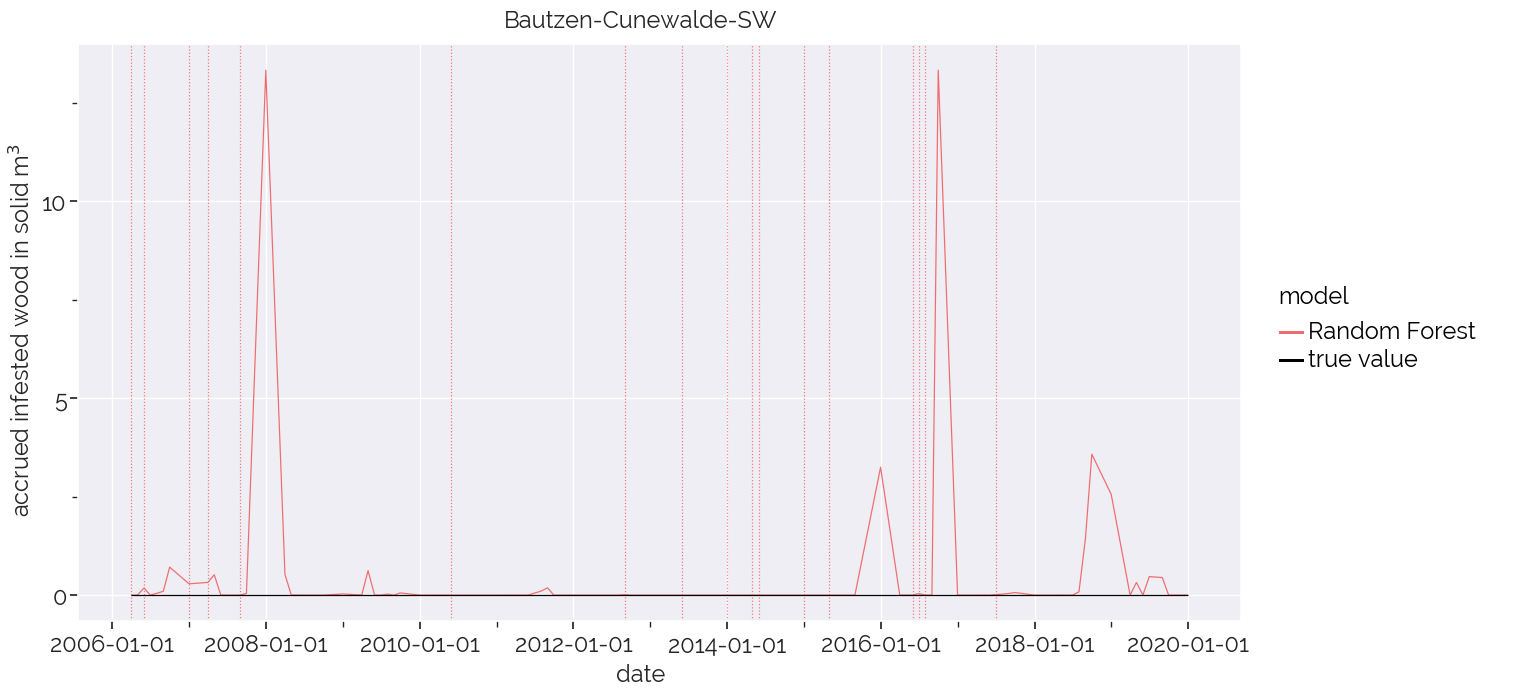

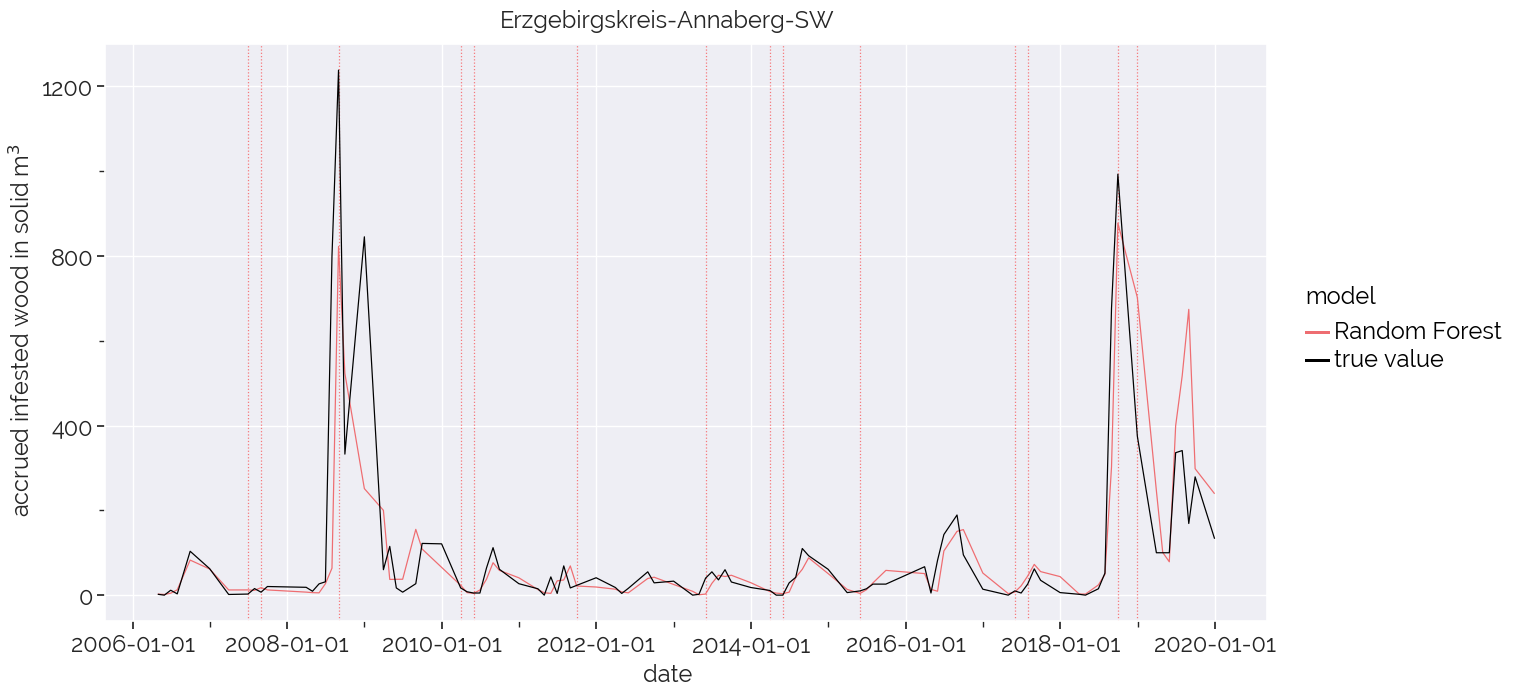

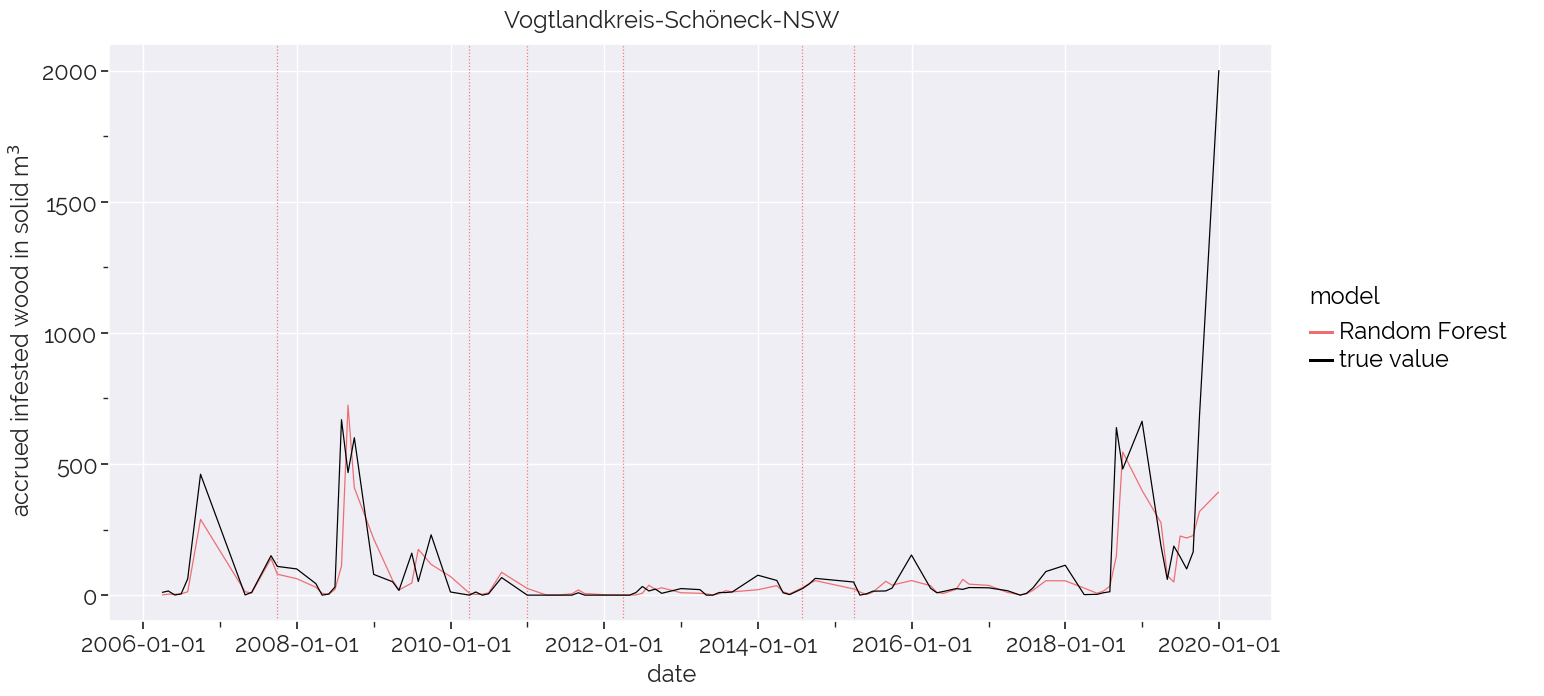

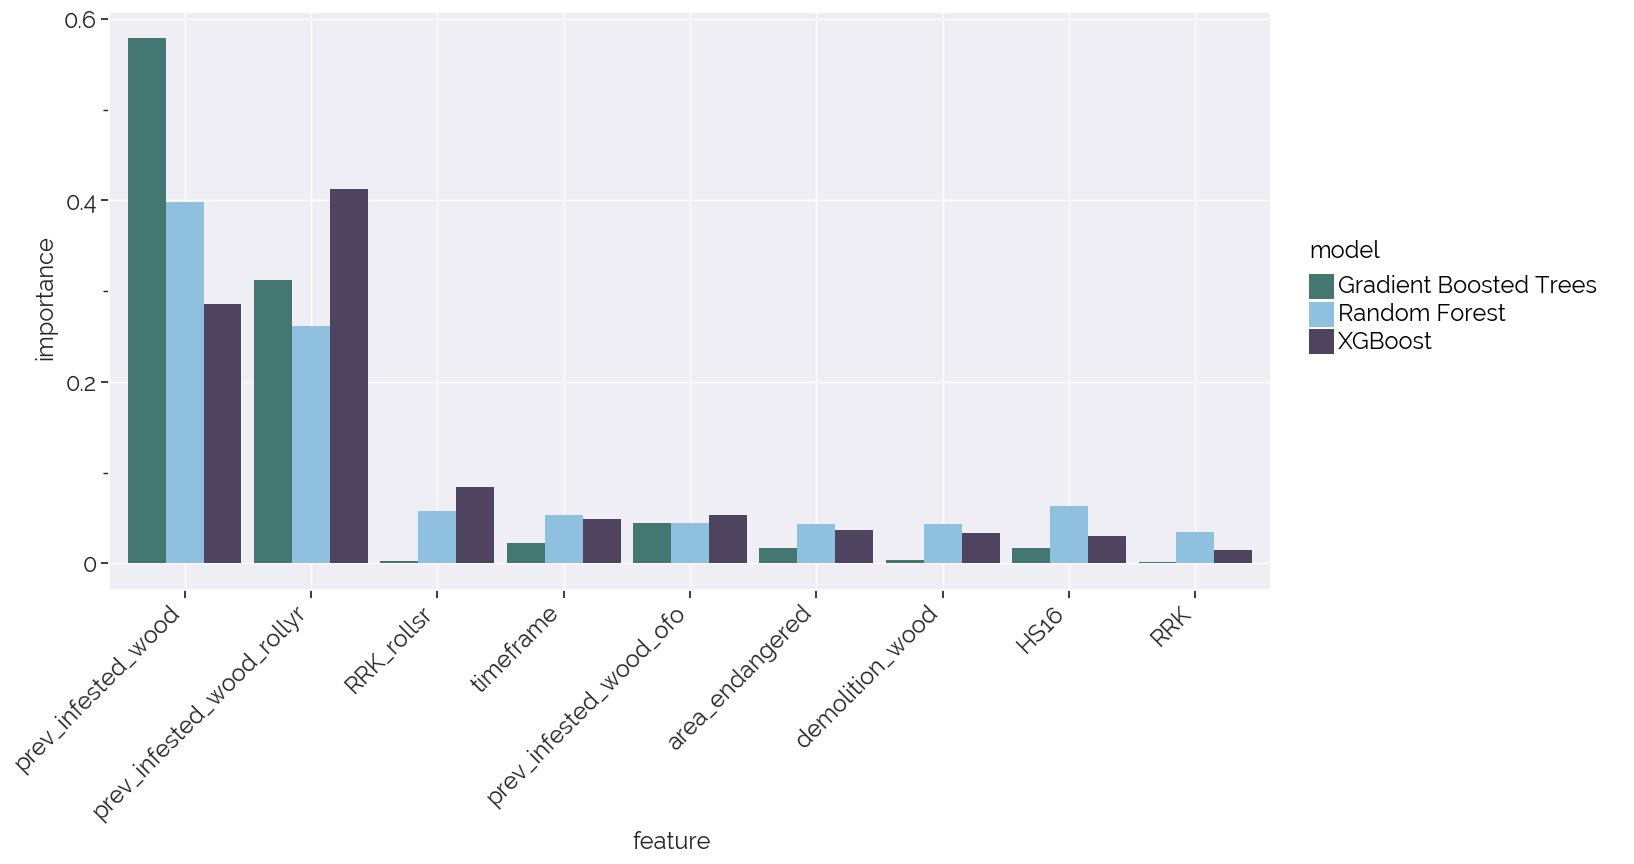

In [23]:
plot_results(results_df, best_models, grid_dict, X_train, X_val, y_train, y_val)

# 5 Model with liberal approach